# Training
This notebook contains the image processing, architectures and training configuration for the five models I used.

In [1]:
from fastai.vision import *
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pretrainedmodels
import torchvision.models as torch_models

import dataprep
import model_utils_ext as m_util_x
import model_utils as m_util

from efficientnet_pytorch import EfficientNet

import cv2

In [2]:
source = Path('/home/kaggle/bengaliai-cv19/input')

bs = 64 # 64 for Model 3 else 128
EPOCHS_1 = 1 # for submittion model: 10-120
EPOCHS_2 = 1 #  for submittion model: 3-10

## Read the labels

In [3]:
df_label = dataprep.load_labels()
df_label.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic
0,Train_0,15,9,5
1,Train_1,159,0,0
2,Train_2,22,3,5
3,Train_3,53,2,2
4,Train_4,71,9,5


In [4]:
cls_count=[df_label.grapheme_root.nunique(), df_label.vowel_diacritic.nunique(), df_label.consonant_diacritic.nunique()]

print('Number of classes:', cls_count)

Number of classes: [168, 11, 7]


# Load images and create databunch

In [5]:
%%time
data = dataprep.data(bs)

CPU times: user 11.4 s, sys: 6.23 s, total: 17.6 s
Wall time: 14.6 s


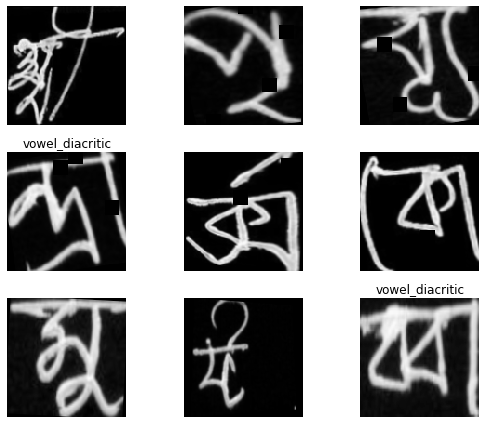

In [6]:
data.show_batch(rows=3, figsize=(8,6))

## Model 1
Modified resnext50

In [7]:
arch = torch_models.resnext50_32x4d

In [8]:
def threeHeads(nf, nc):
    layers =[m_util.HeadBlock(nf,nc)]
    return nn.Sequential(*layers)

In [9]:
learn = cnn_learner(data, arch, cut=-2, custom_head=threeHeads(4096, cls_count), 
                    loss_func = m_util_x.Loss_combine(), 
                    metrics=[m_util_x.Metric_grapheme(),m_util_x.Metric_vowel(),m_util_x.Metric_consonant(),m_util_x.Metric_tot()]).to_fp16()

learn.clip_grad = 1.0
learn.unfreeze()

Add self-attention layer after resnext blocks:

In [10]:
for i in range(3):    
    learn.model[0][4][i].add_module('self_att1',m_util.SAI(256)) #PooledSelfAttention2d

for i in range(4):    
    learn.model[0][5][i].add_module('self_att2',m_util.SAI(512)) #PooledSelfAttention2d

for i in range(6): #23   #6 
    learn.model[0][6][i].add_module('self_att3',m_util.SAI(512)) #PooledSelfAttention2d

for i in range(3):    
    learn.model[0][7][i].add_module('self_att4',m_util.SAI(512)) #PooledSelfAttention2d


In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-03
Min loss divided by 10: 5.75E-03


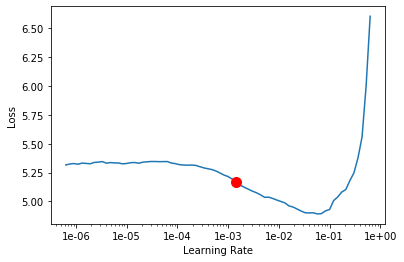

In [12]:
learn.recorder.plot(suggestion=True)

In [13]:
lr = 1e-2
n_cycle = EPOCHS_1 # for competition: 10

In [14]:
csvlogger = callbacks.CSVLogger(learn,'learn_log_1_2')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)

learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, m_util_x.MixUpCallback(learn), csvlogger],pct_start=0.1)


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,1.007725,0.157278,0.917432,0.971929,0.964028,0.942705,07:19


In [15]:
#learn.save('stage1_mod1')

In [16]:
#learn.load('stage1_mod1')

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


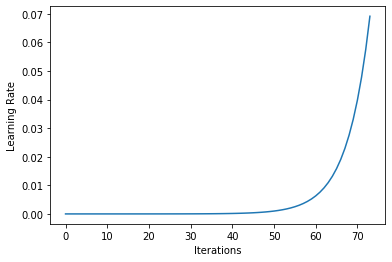

In [18]:
learn.recorder.plot_lr()

In [19]:
lr = 1e-3 
n_cycle = EPOCHS_2 # for competition: 10

In [20]:
csvlogger = callbacks.CSVLogger(learn,'learn_log_1_3')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, m_util_x.MixUpCallback(learn),csvlogger],pct_start=0.1)

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.921197,0.129568,0.933973,0.977969,0.969534,0.953862,07:20


In [21]:
#learn.recorder.plot_losses()

In [22]:
#learn.recorder.plot_lr()

In [23]:
#learn.recorder.plot_metrics()

In [24]:
#learn.save('mymod_160E_SAI_mix_50d_Inv_0pad_2cos')

In [25]:
#learn.export('export_mymod_160E_SAI_mix_50d_Inv_0pad_2cos.pkl')

# Model 2
SE-Resnext 50

In [26]:
def threeHeads(nf, nc):
    layers =[m_util.HeadBlock0(nf,nc)]
    return nn.Sequential(*layers)

In [27]:
learn = cnn_learner(data, m_util.se_resnext50, cut=-2, custom_head=threeHeads(4096, cls_count),  
                    loss_func = m_util_x.Loss_combine(), 
                    metrics=[m_util_x.Metric_grapheme(),m_util_x.Metric_vowel(),m_util_x.Metric_consonant(),m_util_x.Metric_tot()]).to_fp16()

learn.clip_grad = 1.0
learn.unfreeze()

In [28]:
lr = 1e-2
n_cycle = EPOCHS_1 # for competition: 10

csvlogger = callbacks.CSVLogger(learn,'learn_log_2_2')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, m_util_x.MixUpCallback(learn), csvlogger])


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.964728,0.180187,0.914468,0.972906,0.962413,0.941064,09:01


In [29]:
lr = 1e-3
n_cycle = EPOCHS_2 # for competition: 10

csvlogger = callbacks.CSVLogger(learn,'learn_log_2_3')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, m_util_x.MixUpCallback(learn), csvlogger])


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.897643,0.151397,0.931066,0.977292,0.968783,0.952052,09:01


## Model 3
Modified Resnext-100

In [31]:
arch = torch_models.resnext101_32x8d

def threeHeads(nf, nc):
    layers =[m_util.HeadBlock0(nf,nc)]
    return nn.Sequential(*layers)

In [32]:
learn = cnn_learner(data, arch, cut=-2, custom_head=threeHeads(4096, cls_count), 
                    loss_func = m_util_x.Loss_combine(), 
                    metrics=[m_util_x.Metric_grapheme(),m_util_x.Metric_vowel(),m_util_x.Metric_consonant(),m_util_x.Metric_tot()]).to_fp16()

learn.clip_grad = 1.0
learn.unfreeze()

In [33]:
for i in range(3):    
    learn.model[0][4][i].add_module('self_att1',m_util.SAI(256)) #PooledSelfAttention2d

for i in range(4):    
    learn.model[0][5][i].add_module('self_att2',m_util.SAI(512)) #PooledSelfAttention2d

for i in range(23): #23   #6 
    learn.model[0][6][i].add_module('self_att3',m_util.SAI(512)) #PooledSelfAttention2d

for i in range(3):    
    learn.model[0][7][i].add_module('self_att4',m_util.SAI(512)) #PooledSelfAttention2d


In [34]:
lr = 1e-2
n_cycle = EPOCHS_1 # for competition: 10

csvlogger = callbacks.CSVLogger(learn,'learn_log_3_2')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, m_util_x.MixUpCallback(learn), csvlogger])


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.977994,0.154423,0.927580,0.973150,0.963660,0.947993,17:17


In [35]:
lr = 1e-3
n_cycle = EPOCHS_2 # for competition: 10

csvlogger = callbacks.CSVLogger(learn,'learn_log_3_3')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, m_util_x.MixUpCallback(learn), csvlogger])


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.918718,0.127092,0.939893,0.979089,0.968643,0.956879,17:14


# Model 4
EfficientNet-b2

In [36]:
def threeHeads(nf, nc):
    layers =[m_util.HeadBlockEff(nf,nc)]
    return nn.Sequential(*layers)

In [37]:
eff_model = EfficientNet.from_pretrained('efficientnet-b2')
eff_model._fc=threeHeads(1408, cls_count)

Loaded pretrained weights for efficientnet-b2


In [38]:
learn = Learner(data, eff_model, 
                loss_func = m_util_x.Loss_combine(), 
                metrics=[m_util_x.Metric_grapheme(),m_util_x.Metric_vowel(),m_util_x.Metric_consonant(),m_util_x.Metric_tot()]).to_fp16()

learn.clip_grad = 1.0
learn.unfreeze()

In [39]:
lr = 1e-2
n_cycle = EPOCHS_1 # for competition: 120 

csvlogger = callbacks.CSVLogger(learn,'learn_log_4_2')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, m_util_x.MixUpCallback(learn), csvlogger])


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,1.001979,0.167767,0.919124,0.967529,0.953420,0.939799,09:02


In [40]:
lr = 3.63e-3
n_cycle = EPOCHS_2 # for competition: 3

csvlogger = callbacks.CSVLogger(learn,'learn_log_4_2')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, csvlogger],pct_start=0.1)


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.159579,0.121976,0.942224,0.977900,0.972189,0.958635,08:53


## Model 5
EfficientNet-b4

In [41]:
def threeHeads(nf, nc):
    layers =[m_util.HeadBlockEff(nf,nc)]
    return nn.Sequential(*layers)

In [42]:
eff_model = EfficientNet.from_pretrained('efficientnet-b4')
eff_model._fc=threeHeads(1792, cls_count)

Loaded pretrained weights for efficientnet-b4


In [43]:
lr = 1e-2
n_cycle = EPOCHS_1 # for competition: 10

csvlogger = callbacks.CSVLogger(learn,'learn_log_5_2')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, m_util_x.MixUpCallback(learn), csvlogger],pct_start=0.1)


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.933493,0.136639,0.936896,0.976579,0.965310,0.953921,08:56


In [44]:
lr = 1e-3
n_cycle = EPOCHS_2 # for competition: 10

csvlogger = callbacks.CSVLogger(learn,'learn_log_5_2')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, csvlogger])


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.144362,0.114246,0.944619,0.979547,0.971083,0.959967,08:53
